In [1]:
import numpy as np
import math
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import glob
import gc
from utils import *
from tqdm import tqdm
import pickle

from keras.optimizers import *
from keras.models import Model
from keras.layers import *
from keras.layers.core import *
from keras.layers.convolutional import *
from keras import backend as K
import tensorflow as tf

Using TensorFlow backend.


# Initialize the setting

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device



In [9]:
random.seed(1234)

class Config():
    def __init__(self):
        self.frame_l = 32 # the length of frames
        self.joint_n = 25 # the number of joints
        self.joint_d = 2 # the dimension of joints
        self.clc_num = 21 # the number of class
        self.feat_d = 300
        self.filters = 64
        self.data_dir = os.path.join(os.path.abspath(''), '..', 'data', 'openpose_all_jhmdb_hybrid')
C = Config()

In [10]:
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))): 
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]-1] = 1   

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)  
    X_1 = np.stack(X_1) 
    Y = np.stack(Y)
    return X_0,X_1,Y

# Building the model

In [11]:
def poses_diff(x):
    H, W = x.get_shape()[1],x.get_shape()[2]
    x = tf.subtract(x[:,1:,...],x[:,:-1,...])
    x = tf.image.resize_nearest_neighbor(x,size=[H.value,W.value],align_corners=False) # should not alignment here
    return x

def pose_motion(P,frame_l):
    P_diff_slow = Lambda(lambda x: poses_diff(x))(P)
    P_diff_slow = Reshape((frame_l,-1))(P_diff_slow)
    P_fast = Lambda(lambda x: x[:,::2,...])(P)
    P_diff_fast = Lambda(lambda x: poses_diff(x))(P_fast)
    P_diff_fast = Reshape((int(frame_l/2),-1))(P_diff_fast)
    return P_diff_slow,P_diff_fast
    
def c1D(x,filters,kernel):
    x = Conv1D(filters, kernel_size=kernel,padding='same',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x,filters):
    x = c1D(x,filters,3)
    x = c1D(x,filters,3)
    return x
    
def d1D(x,filters):
    x = Dense(filters,use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def build_FM(frame_l=32,joint_n=22,joint_d=2,feat_d=231,filters=16):   
    M = Input(shape=(frame_l,feat_d))
    P = Input(shape=(frame_l,joint_n,joint_d))
    
    diff_slow,diff_fast = pose_motion(P,frame_l)
    
    x = c1D(M,filters*2,1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x,filters,1)
    x = MaxPooling1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x_d_slow = c1D(diff_slow,filters*2,1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow,filters,1)
    x_d_slow = MaxPool1D(2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
        
    x_d_fast = c1D(diff_fast,filters*2,1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,3) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast,filters,1) 
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
   
    x = concatenate([x,x_d_slow,x_d_fast])
    x = block(x,filters*2)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)
    
    x = block(x,filters*4)
    x = MaxPool1D(2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x,filters*8)
    x = SpatialDropout1D(0.1)(x)
    
    return Model(inputs=[M,P],outputs=x)


def build_DD_Net(C):
    M = Input(name='M', shape=(C.frame_l,C.feat_d))  
    P = Input(name='P', shape=(C.frame_l,C.joint_n,C.joint_d)) 
    
    FM = build_FM(C.frame_l,C.joint_n,C.joint_d,C.feat_d,C.filters)
    
    x = FM([M,P])

    x = GlobalMaxPool1D()(x)
    
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = d1D(x,128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)
    
    ######################Self-supervised part
    model = Model(inputs=[M,P],outputs=x)
    return model

In [12]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
M (InputLayer)                  (None, 32, 300)      0                                            
__________________________________________________________________________________________________
P (InputLayer)                  (None, 32, 25, 2)    0                                            
__________________________________________________________________________________________________
model_3 (Model)                 (None, 4, 512)       1744896     M[0][0]                          
                                                                 P[0][0]                          
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 512)          0           model_3[1][0]              

## Train and test on GT_split 1

In [13]:
Train = pickle.load(open(os.path.join(C.data_dir, "GT_train_1.pkl"), "rb"))
Test = pickle.load(open(os.path.join(C.data_dir, "GT_test_1.pkl"), "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 195/195 [00:00<00:00, 252.85it/s]


In [14]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )


Train on 497 samples, validate on 195 samples
Epoch 1/600
497/497 [==============================] - 3s 7ms/step - loss: 3.9961 - accuracy: 0.0201 - val_loss: 3.4324 - val_accuracy: 0.0308
Epoch 2/600
497/497 [==============================] - 0s 470us/step - loss: 3.6034 - accuracy: 0.0503 - val_loss: 3.5655 - val_accuracy: 0.0308
Epoch 3/600
497/497 [==============================] - 0s 439us/step - loss: 3.4175 - accuracy: 0.0966 - val_loss: 3.5209 - val_accuracy: 0.0308
Epoch 4/600
497/497 [==============================] - 0s 442us/step - loss: 3.2207 - accuracy: 0.1388 - val_loss: 3.4545 - val_accuracy: 0.0615
Epoch 5/600
497/497 [==============================] - 0s 437us/step - loss: 3.1410 - accuracy: 0.1429 - val_loss: 3.3888 - val_accuracy: 0.0615
Epoch 6/600
497/497 [==============================] - 0s 407us/step - loss: 3.0621 - accuracy: 0.1710 - val_loss: 3.3933 - val_accuracy: 0.1179
Epoch 7/600
497/497 [==============================] - 0s 415us/step - loss: 2.8908 -

Epoch 56/600
497/497 [==============================] - 0s 422us/step - loss: 0.8714 - accuracy: 0.7726 - val_loss: 2.5089 - val_accuracy: 0.2051
Epoch 57/600
497/497 [==============================] - 0s 412us/step - loss: 0.8610 - accuracy: 0.7425 - val_loss: 2.4882 - val_accuracy: 0.2154
Epoch 58/600
497/497 [==============================] - 0s 419us/step - loss: 0.8335 - accuracy: 0.7726 - val_loss: 2.4631 - val_accuracy: 0.2410
Epoch 59/600
497/497 [==============================] - 0s 424us/step - loss: 0.8158 - accuracy: 0.7948 - val_loss: 2.4378 - val_accuracy: 0.2564
Epoch 60/600
497/497 [==============================] - 0s 434us/step - loss: 0.7725 - accuracy: 0.7887 - val_loss: 2.4249 - val_accuracy: 0.2769
Epoch 61/600
497/497 [==============================] - 0s 400us/step - loss: 0.7871 - accuracy: 0.7787 - val_loss: 2.4180 - val_accuracy: 0.2872
Epoch 62/600
497/497 [==============================] - 0s 410us/step - loss: 0.7980 - accuracy: 0.7827 - val_loss: 2.4156 -

Epoch 113/600
497/497 [==============================] - 0s 390us/step - loss: 0.2149 - accuracy: 0.9738 - val_loss: 2.2407 - val_accuracy: 0.3795
Epoch 114/600
497/497 [==============================] - 0s 382us/step - loss: 0.2235 - accuracy: 0.9698 - val_loss: 2.2421 - val_accuracy: 0.3795
Epoch 115/600
497/497 [==============================] - 0s 400us/step - loss: 0.2348 - accuracy: 0.9658 - val_loss: 2.2396 - val_accuracy: 0.3744
Epoch 116/600
497/497 [==============================] - 0s 384us/step - loss: 0.2351 - accuracy: 0.9618 - val_loss: 2.2392 - val_accuracy: 0.3795
Epoch 117/600
497/497 [==============================] - 0s 382us/step - loss: 0.1963 - accuracy: 0.9799 - val_loss: 2.2401 - val_accuracy: 0.3744
Epoch 118/600
497/497 [==============================] - 0s 394us/step - loss: 0.2036 - accuracy: 0.9819 - val_loss: 2.2360 - val_accuracy: 0.3744
Epoch 119/600
497/497 [==============================] - 0s 403us/step - loss: 0.1789 - accuracy: 0.9879 - val_loss: 2

Epoch 169/600
497/497 [==============================] - 0s 386us/step - loss: 0.1448 - accuracy: 0.9899 - val_loss: 2.1204 - val_accuracy: 0.4615
Epoch 170/600
497/497 [==============================] - 0s 381us/step - loss: 0.1718 - accuracy: 0.9799 - val_loss: 2.1196 - val_accuracy: 0.4615
Epoch 171/600
497/497 [==============================] - 0s 442us/step - loss: 0.1581 - accuracy: 0.9920 - val_loss: 2.1188 - val_accuracy: 0.4615
Epoch 172/600
497/497 [==============================] - 0s 409us/step - loss: 0.1662 - accuracy: 0.9839 - val_loss: 2.1179 - val_accuracy: 0.4564
Epoch 173/600
497/497 [==============================] - 0s 409us/step - loss: 0.1501 - accuracy: 0.9879 - val_loss: 2.1172 - val_accuracy: 0.4615
Epoch 174/600
497/497 [==============================] - 0s 413us/step - loss: 0.1689 - accuracy: 0.9839 - val_loss: 2.1163 - val_accuracy: 0.4615
Epoch 175/600
497/497 [==============================] - 0s 404us/step - loss: 0.1487 - accuracy: 0.9839 - val_loss: 2

Epoch 225/600
497/497 [==============================] - 0s 417us/step - loss: 0.1769 - accuracy: 0.9759 - val_loss: 2.0961 - val_accuracy: 0.4974
Epoch 226/600
497/497 [==============================] - 0s 384us/step - loss: 0.1615 - accuracy: 0.9879 - val_loss: 2.0959 - val_accuracy: 0.4974
Epoch 227/600
497/497 [==============================] - 0s 382us/step - loss: 0.1423 - accuracy: 0.9879 - val_loss: 2.0958 - val_accuracy: 0.4974
Epoch 228/600
497/497 [==============================] - 0s 381us/step - loss: 0.1715 - accuracy: 0.9799 - val_loss: 2.0954 - val_accuracy: 0.4974
Epoch 229/600
497/497 [==============================] - 0s 402us/step - loss: 0.1576 - accuracy: 0.9839 - val_loss: 2.0956 - val_accuracy: 0.4974
Epoch 230/600
497/497 [==============================] - 0s 396us/step - loss: 0.1558 - accuracy: 0.9899 - val_loss: 2.0956 - val_accuracy: 0.4923
Epoch 231/600
497/497 [==============================] - 0s 398us/step - loss: 0.1429 - accuracy: 0.9980 - val_loss: 2

Epoch 281/600
497/497 [==============================] - 0s 393us/step - loss: 0.1442 - accuracy: 0.9940 - val_loss: 2.0975 - val_accuracy: 0.4872
Epoch 282/600
497/497 [==============================] - 0s 382us/step - loss: 0.1669 - accuracy: 0.9859 - val_loss: 2.0975 - val_accuracy: 0.4872
Epoch 283/600
497/497 [==============================] - 0s 410us/step - loss: 0.1470 - accuracy: 0.9879 - val_loss: 2.0972 - val_accuracy: 0.4872
Epoch 284/600
497/497 [==============================] - 0s 400us/step - loss: 0.1753 - accuracy: 0.9839 - val_loss: 2.0970 - val_accuracy: 0.4872
Epoch 285/600
497/497 [==============================] - 0s 401us/step - loss: 0.1644 - accuracy: 0.9779 - val_loss: 2.0974 - val_accuracy: 0.4872
Epoch 286/600
497/497 [==============================] - 0s 432us/step - loss: 0.1494 - accuracy: 0.9899 - val_loss: 2.0973 - val_accuracy: 0.4872
Epoch 287/600
497/497 [==============================] - 0s 381us/step - loss: 0.1568 - accuracy: 0.9899 - val_loss: 2

Epoch 337/600
497/497 [==============================] - 0s 395us/step - loss: 0.1452 - accuracy: 0.9899 - val_loss: 2.0961 - val_accuracy: 0.4769
Epoch 338/600
497/497 [==============================] - 0s 428us/step - loss: 0.1563 - accuracy: 0.9879 - val_loss: 2.0960 - val_accuracy: 0.4769
Epoch 339/600
497/497 [==============================] - 0s 384us/step - loss: 0.1365 - accuracy: 0.9859 - val_loss: 2.0958 - val_accuracy: 0.4769
Epoch 340/600
497/497 [==============================] - 0s 426us/step - loss: 0.1732 - accuracy: 0.9859 - val_loss: 2.0962 - val_accuracy: 0.4769
Epoch 341/600
497/497 [==============================] - 0s 400us/step - loss: 0.1454 - accuracy: 0.9940 - val_loss: 2.0963 - val_accuracy: 0.4769
Epoch 342/600
497/497 [==============================] - 0s 422us/step - loss: 0.1679 - accuracy: 0.9738 - val_loss: 2.0966 - val_accuracy: 0.4769
Epoch 343/600
497/497 [==============================] - 0s 417us/step - loss: 0.1580 - accuracy: 0.9920 - val_loss: 2

Epoch 393/600
497/497 [==============================] - 0s 387us/step - loss: 0.1603 - accuracy: 0.9799 - val_loss: 2.1079 - val_accuracy: 0.4769
Epoch 394/600
497/497 [==============================] - 0s 395us/step - loss: 0.1700 - accuracy: 0.9819 - val_loss: 2.1083 - val_accuracy: 0.4769
Epoch 395/600
497/497 [==============================] - 0s 401us/step - loss: 0.1458 - accuracy: 0.9899 - val_loss: 2.1085 - val_accuracy: 0.4769
Epoch 396/600
497/497 [==============================] - 0s 426us/step - loss: 0.1519 - accuracy: 0.9899 - val_loss: 2.1090 - val_accuracy: 0.4769
Epoch 397/600
497/497 [==============================] - 0s 381us/step - loss: 0.1299 - accuracy: 0.9879 - val_loss: 2.1092 - val_accuracy: 0.4769
Epoch 398/600
497/497 [==============================] - 0s 431us/step - loss: 0.1408 - accuracy: 0.9839 - val_loss: 2.1098 - val_accuracy: 0.4769
Epoch 399/600
497/497 [==============================] - 0s 399us/step - loss: 0.1658 - accuracy: 0.9839 - val_loss: 2

Epoch 449/600
497/497 [==============================] - 0s 407us/step - loss: 0.1588 - accuracy: 0.9899 - val_loss: 2.1091 - val_accuracy: 0.4769
Epoch 450/600
497/497 [==============================] - 0s 395us/step - loss: 0.1435 - accuracy: 0.9859 - val_loss: 2.1093 - val_accuracy: 0.4769
Epoch 451/600
497/497 [==============================] - 0s 395us/step - loss: 0.1384 - accuracy: 0.9859 - val_loss: 2.1091 - val_accuracy: 0.4769
Epoch 452/600
497/497 [==============================] - 0s 394us/step - loss: 0.1523 - accuracy: 0.9859 - val_loss: 2.1091 - val_accuracy: 0.4769
Epoch 453/600
497/497 [==============================] - 0s 429us/step - loss: 0.1524 - accuracy: 0.9839 - val_loss: 2.1091 - val_accuracy: 0.4769
Epoch 454/600
497/497 [==============================] - 0s 389us/step - loss: 0.1522 - accuracy: 0.9859 - val_loss: 2.1088 - val_accuracy: 0.4769
Epoch 455/600
497/497 [==============================] - 0s 427us/step - loss: 0.1542 - accuracy: 0.9839 - val_loss: 2

Epoch 505/600
497/497 [==============================] - 0s 393us/step - loss: 0.1515 - accuracy: 0.9920 - val_loss: 2.1127 - val_accuracy: 0.4769
Epoch 506/600
497/497 [==============================] - 0s 422us/step - loss: 0.1617 - accuracy: 0.9859 - val_loss: 2.1128 - val_accuracy: 0.4769
Epoch 507/600
497/497 [==============================] - 0s 393us/step - loss: 0.1530 - accuracy: 0.9839 - val_loss: 2.1128 - val_accuracy: 0.4769
Epoch 508/600
497/497 [==============================] - 0s 391us/step - loss: 0.1529 - accuracy: 0.9920 - val_loss: 2.1128 - val_accuracy: 0.4769
Epoch 509/600
497/497 [==============================] - 0s 390us/step - loss: 0.1403 - accuracy: 0.9899 - val_loss: 2.1129 - val_accuracy: 0.4769
Epoch 510/600
497/497 [==============================] - 0s 401us/step - loss: 0.1706 - accuracy: 0.9839 - val_loss: 2.1131 - val_accuracy: 0.4769
Epoch 511/600
497/497 [==============================] - 0s 399us/step - loss: 0.1323 - accuracy: 0.9899 - val_loss: 2

Epoch 561/600
497/497 [==============================] - 0s 411us/step - loss: 0.1538 - accuracy: 0.9879 - val_loss: 2.1131 - val_accuracy: 0.4769
Epoch 562/600
497/497 [==============================] - 0s 434us/step - loss: 0.1501 - accuracy: 0.9859 - val_loss: 2.1133 - val_accuracy: 0.4769
Epoch 563/600
497/497 [==============================] - 0s 386us/step - loss: 0.1531 - accuracy: 0.9920 - val_loss: 2.1131 - val_accuracy: 0.4769
Epoch 564/600
497/497 [==============================] - 0s 443us/step - loss: 0.1347 - accuracy: 0.9879 - val_loss: 2.1131 - val_accuracy: 0.4769
Epoch 565/600
497/497 [==============================] - 0s 406us/step - loss: 0.1568 - accuracy: 0.9799 - val_loss: 2.1128 - val_accuracy: 0.4769
Epoch 566/600
497/497 [==============================] - 0s 392us/step - loss: 0.1488 - accuracy: 0.9899 - val_loss: 2.1130 - val_accuracy: 0.4769
Epoch 567/600
497/497 [==============================] - 0s 398us/step - loss: 0.1576 - accuracy: 0.9819 - val_loss: 2

Epoch 17/600
497/497 [==============================] - 0s 380us/step - loss: 0.1526 - accuracy: 0.9738 - val_loss: 2.1666 - val_accuracy: 0.4872
Epoch 18/600
497/497 [==============================] - 0s 391us/step - loss: 0.1347 - accuracy: 0.9819 - val_loss: 2.1637 - val_accuracy: 0.4872
Epoch 19/600
497/497 [==============================] - 0s 404us/step - loss: 0.1509 - accuracy: 0.9839 - val_loss: 2.1613 - val_accuracy: 0.4872
Epoch 20/600
497/497 [==============================] - 0s 390us/step - loss: 0.1388 - accuracy: 0.9819 - val_loss: 2.1586 - val_accuracy: 0.4821
Epoch 21/600
497/497 [==============================] - 0s 377us/step - loss: 0.1258 - accuracy: 0.9940 - val_loss: 2.1545 - val_accuracy: 0.4821
Epoch 22/600
497/497 [==============================] - 0s 416us/step - loss: 0.1113 - accuracy: 0.9940 - val_loss: 2.1498 - val_accuracy: 0.4821
Epoch 23/600
497/497 [==============================] - 0s 404us/step - loss: 0.1445 - accuracy: 0.9899 - val_loss: 2.1461 -

Epoch 74/600
497/497 [==============================] - 0s 399us/step - loss: 0.1215 - accuracy: 0.9920 - val_loss: 2.1632 - val_accuracy: 0.4769
Epoch 75/600
497/497 [==============================] - 0s 395us/step - loss: 0.1441 - accuracy: 0.9839 - val_loss: 2.1626 - val_accuracy: 0.4769
Epoch 76/600
497/497 [==============================] - 0s 395us/step - loss: 0.1259 - accuracy: 0.9920 - val_loss: 2.1625 - val_accuracy: 0.4769
Epoch 77/600
497/497 [==============================] - 0s 379us/step - loss: 0.1303 - accuracy: 0.9920 - val_loss: 2.1627 - val_accuracy: 0.4769
Epoch 78/600
497/497 [==============================] - 0s 393us/step - loss: 0.1508 - accuracy: 0.9799 - val_loss: 2.1625 - val_accuracy: 0.4769
Epoch 79/600
497/497 [==============================] - 0s 386us/step - loss: 0.1486 - accuracy: 0.9819 - val_loss: 2.1624 - val_accuracy: 0.4769
Epoch 80/600
497/497 [==============================] - 0s 404us/step - loss: 0.1310 - accuracy: 0.9899 - val_loss: 2.1619 -

Epoch 130/600
497/497 [==============================] - 0s 397us/step - loss: 0.1193 - accuracy: 0.9940 - val_loss: 2.1557 - val_accuracy: 0.4821
Epoch 131/600
497/497 [==============================] - 0s 394us/step - loss: 0.1516 - accuracy: 0.9819 - val_loss: 2.1563 - val_accuracy: 0.4821
Epoch 132/600
497/497 [==============================] - 0s 397us/step - loss: 0.1456 - accuracy: 0.9819 - val_loss: 2.1563 - val_accuracy: 0.4872
Epoch 133/600
497/497 [==============================] - 0s 386us/step - loss: 0.1200 - accuracy: 0.9960 - val_loss: 2.1570 - val_accuracy: 0.4872
Epoch 134/600
497/497 [==============================] - 0s 393us/step - loss: 0.1307 - accuracy: 0.9920 - val_loss: 2.1573 - val_accuracy: 0.4872
Epoch 135/600
497/497 [==============================] - 0s 381us/step - loss: 0.1427 - accuracy: 0.9738 - val_loss: 2.1574 - val_accuracy: 0.4872
Epoch 136/600
497/497 [==============================] - 0s 379us/step - loss: 0.1454 - accuracy: 0.9819 - val_loss: 2

Epoch 186/600
497/497 [==============================] - 0s 403us/step - loss: 0.1216 - accuracy: 0.9899 - val_loss: 2.1607 - val_accuracy: 0.4872
Epoch 187/600
497/497 [==============================] - 0s 408us/step - loss: 0.1141 - accuracy: 0.9920 - val_loss: 2.1612 - val_accuracy: 0.4872
Epoch 188/600
497/497 [==============================] - 0s 398us/step - loss: 0.1129 - accuracy: 0.9980 - val_loss: 2.1619 - val_accuracy: 0.4872
Epoch 189/600
497/497 [==============================] - 0s 404us/step - loss: 0.1391 - accuracy: 0.9839 - val_loss: 2.1623 - val_accuracy: 0.4872
Epoch 190/600
497/497 [==============================] - 0s 393us/step - loss: 0.1269 - accuracy: 0.9899 - val_loss: 2.1629 - val_accuracy: 0.4872
Epoch 191/600
497/497 [==============================] - 0s 394us/step - loss: 0.1338 - accuracy: 0.9879 - val_loss: 2.1633 - val_accuracy: 0.4872
Epoch 192/600
497/497 [==============================] - 0s 402us/step - loss: 0.1383 - accuracy: 0.9839 - val_loss: 2

Epoch 242/600
497/497 [==============================] - 0s 394us/step - loss: 0.1313 - accuracy: 0.9899 - val_loss: 2.1677 - val_accuracy: 0.4821
Epoch 243/600
497/497 [==============================] - 0s 393us/step - loss: 0.1300 - accuracy: 0.9899 - val_loss: 2.1682 - val_accuracy: 0.4821
Epoch 244/600
497/497 [==============================] - 0s 387us/step - loss: 0.1327 - accuracy: 0.9839 - val_loss: 2.1686 - val_accuracy: 0.4821
Epoch 245/600
497/497 [==============================] - 0s 401us/step - loss: 0.1220 - accuracy: 0.9960 - val_loss: 2.1688 - val_accuracy: 0.4821
Epoch 246/600
497/497 [==============================] - 0s 387us/step - loss: 0.1118 - accuracy: 0.9940 - val_loss: 2.1696 - val_accuracy: 0.4821
Epoch 247/600
497/497 [==============================] - 0s 401us/step - loss: 0.1382 - accuracy: 0.9899 - val_loss: 2.1703 - val_accuracy: 0.4821
Epoch 248/600
497/497 [==============================] - 0s 389us/step - loss: 0.1319 - accuracy: 0.9879 - val_loss: 2

Epoch 298/600
497/497 [==============================] - 0s 393us/step - loss: 0.1223 - accuracy: 0.9960 - val_loss: 2.1724 - val_accuracy: 0.4769
Epoch 299/600
497/497 [==============================] - 0s 383us/step - loss: 0.1194 - accuracy: 0.9940 - val_loss: 2.1726 - val_accuracy: 0.4769
Epoch 300/600
497/497 [==============================] - 0s 390us/step - loss: 0.1366 - accuracy: 0.9899 - val_loss: 2.1725 - val_accuracy: 0.4769
Epoch 301/600
497/497 [==============================] - 0s 405us/step - loss: 0.1228 - accuracy: 0.9879 - val_loss: 2.1725 - val_accuracy: 0.4769
Epoch 302/600
497/497 [==============================] - 0s 370us/step - loss: 0.1257 - accuracy: 0.9879 - val_loss: 2.1725 - val_accuracy: 0.4769
Epoch 303/600
497/497 [==============================] - 0s 391us/step - loss: 0.1238 - accuracy: 0.9920 - val_loss: 2.1725 - val_accuracy: 0.4769
Epoch 304/600
497/497 [==============================] - 0s 395us/step - loss: 0.1185 - accuracy: 0.9920 - val_loss: 2

Epoch 354/600
497/497 [==============================] - 0s 416us/step - loss: 0.1185 - accuracy: 0.9940 - val_loss: 2.1723 - val_accuracy: 0.4872
Epoch 355/600
497/497 [==============================] - 0s 425us/step - loss: 0.1133 - accuracy: 0.9839 - val_loss: 2.1724 - val_accuracy: 0.4872
Epoch 356/600
497/497 [==============================] - 0s 419us/step - loss: 0.1219 - accuracy: 0.9960 - val_loss: 2.1722 - val_accuracy: 0.4872
Epoch 357/600
497/497 [==============================] - 0s 393us/step - loss: 0.1279 - accuracy: 0.9819 - val_loss: 2.1722 - val_accuracy: 0.4872
Epoch 358/600
497/497 [==============================] - 0s 415us/step - loss: 0.1114 - accuracy: 0.9839 - val_loss: 2.1723 - val_accuracy: 0.4872
Epoch 359/600
497/497 [==============================] - 0s 391us/step - loss: 0.1257 - accuracy: 0.9859 - val_loss: 2.1723 - val_accuracy: 0.4872
Epoch 360/600
497/497 [==============================] - 0s 408us/step - loss: 0.1369 - accuracy: 0.9920 - val_loss: 2

Epoch 410/600
497/497 [==============================] - 0s 377us/step - loss: 0.1323 - accuracy: 0.9859 - val_loss: 2.1650 - val_accuracy: 0.4872
Epoch 411/600
497/497 [==============================] - 0s 382us/step - loss: 0.1111 - accuracy: 0.9899 - val_loss: 2.1653 - val_accuracy: 0.4872
Epoch 412/600
497/497 [==============================] - 0s 405us/step - loss: 0.1274 - accuracy: 0.9899 - val_loss: 2.1655 - val_accuracy: 0.4872
Epoch 413/600
497/497 [==============================] - 0s 396us/step - loss: 0.1211 - accuracy: 0.9839 - val_loss: 2.1659 - val_accuracy: 0.4872
Epoch 414/600
497/497 [==============================] - 0s 390us/step - loss: 0.1131 - accuracy: 0.9879 - val_loss: 2.1662 - val_accuracy: 0.4872
Epoch 415/600
497/497 [==============================] - 0s 387us/step - loss: 0.1330 - accuracy: 0.9819 - val_loss: 2.1666 - val_accuracy: 0.4872
Epoch 416/600
497/497 [==============================] - 0s 394us/step - loss: 0.1121 - accuracy: 0.9899 - val_loss: 2

Epoch 466/600
497/497 [==============================] - 0s 409us/step - loss: 0.1201 - accuracy: 0.9819 - val_loss: 2.1770 - val_accuracy: 0.4718
Epoch 467/600
497/497 [==============================] - 0s 397us/step - loss: 0.0984 - accuracy: 0.9980 - val_loss: 2.1768 - val_accuracy: 0.4718
Epoch 468/600
497/497 [==============================] - 0s 414us/step - loss: 0.0956 - accuracy: 0.9940 - val_loss: 2.1771 - val_accuracy: 0.4718
Epoch 469/600
497/497 [==============================] - 0s 396us/step - loss: 0.1067 - accuracy: 0.9940 - val_loss: 2.1769 - val_accuracy: 0.4718
Epoch 470/600
497/497 [==============================] - 0s 403us/step - loss: 0.1149 - accuracy: 0.9920 - val_loss: 2.1767 - val_accuracy: 0.4718
Epoch 471/600
497/497 [==============================] - 0s 389us/step - loss: 0.1606 - accuracy: 0.9759 - val_loss: 2.1770 - val_accuracy: 0.4718
Epoch 472/600
497/497 [==============================] - 0s 391us/step - loss: 0.1341 - accuracy: 0.9920 - val_loss: 2

Epoch 522/600
497/497 [==============================] - 0s 388us/step - loss: 0.1225 - accuracy: 0.9859 - val_loss: 2.1760 - val_accuracy: 0.4769
Epoch 523/600
497/497 [==============================] - 0s 400us/step - loss: 0.1110 - accuracy: 0.9920 - val_loss: 2.1760 - val_accuracy: 0.4769
Epoch 524/600
497/497 [==============================] - 0s 397us/step - loss: 0.1260 - accuracy: 0.9940 - val_loss: 2.1763 - val_accuracy: 0.4769
Epoch 525/600
497/497 [==============================] - 0s 387us/step - loss: 0.1171 - accuracy: 0.9879 - val_loss: 2.1763 - val_accuracy: 0.4769
Epoch 526/600
497/497 [==============================] - 0s 381us/step - loss: 0.1187 - accuracy: 0.9859 - val_loss: 2.1762 - val_accuracy: 0.4821
Epoch 527/600
497/497 [==============================] - 0s 389us/step - loss: 0.1334 - accuracy: 0.9859 - val_loss: 2.1765 - val_accuracy: 0.4821
Epoch 528/600
497/497 [==============================] - 0s 384us/step - loss: 0.1171 - accuracy: 0.9920 - val_loss: 2

Epoch 578/600
497/497 [==============================] - 0s 407us/step - loss: 0.1261 - accuracy: 0.9859 - val_loss: 2.1844 - val_accuracy: 0.4769
Epoch 579/600
497/497 [==============================] - 0s 398us/step - loss: 0.1055 - accuracy: 0.9940 - val_loss: 2.1846 - val_accuracy: 0.4769
Epoch 580/600
497/497 [==============================] - 0s 392us/step - loss: 0.1162 - accuracy: 0.9940 - val_loss: 2.1849 - val_accuracy: 0.4769
Epoch 581/600
497/497 [==============================] - 0s 395us/step - loss: 0.1192 - accuracy: 0.9879 - val_loss: 2.1852 - val_accuracy: 0.4769
Epoch 582/600
497/497 [==============================] - 0s 414us/step - loss: 0.1221 - accuracy: 0.9899 - val_loss: 2.1854 - val_accuracy: 0.4769
Epoch 583/600
497/497 [==============================] - 0s 388us/step - loss: 0.1182 - accuracy: 0.9960 - val_loss: 2.1857 - val_accuracy: 0.4769
Epoch 584/600
497/497 [==============================] - 0s 400us/step - loss: 0.0992 - accuracy: 0.9920 - val_loss: 2

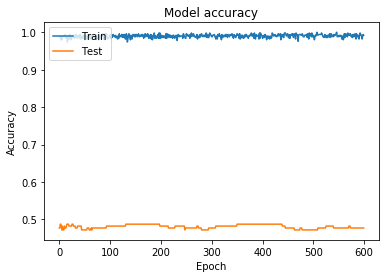

In [15]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [95]:
pose_label = pickle.load(open('/home/ubuntu/roger_actions_output/pose_label.pkl', 'rb'))
x_0, x_1, y = data_generator(pose_label,C,le)

100%|██████████| 4/4 [00:00<00:00, 132.51it/s]


In [127]:
for result in y:
    print(np.argmax(result))

1
1
19
19


In [106]:
output = DD_Net.predict([X_0,X_1])

In [112]:
for i, label in zip(range(len(X_0)), Train['label']):
    print(np.argmax(output[i]), label)

9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
9 push
15 stand
15 stand
15 stand
15 stand
15 stand
15 stand
15 stand
15 stand
15 stand
15 stand
15 stand
15 stand
15 stand
15 stand
10 run
10 run
10 run
10 run
10 run
10 run
10 run
10 run
10 run
10 run
10 run
10 run
10 run
10 run
10 run
10 run
11 shoot_ball
11 shoot_ball
11 shoot_ball
11 shoot_ball
11 shoot_ball
11 shoot_ball
11 shoot_ball
11 shoot_ball
11 shoot_ball
11 shoot_ball
11 shoot_ball
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
1 clap
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8 pullup
8

In [124]:
le.inverse_transform([20])

array(['wave'], dtype='<U14')

In [128]:
le.transform(['clap'])

array([2])

In [125]:
y[2].shape

(21,)

## Train and test on GT_split 2

In [14]:
Train = pickle.load(open(C.data_dir+"GT_train_2.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_2.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 270/270 [00:00<00:00, 326.62it/s]


In [15]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)

In [ ]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    #callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )
lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    #callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

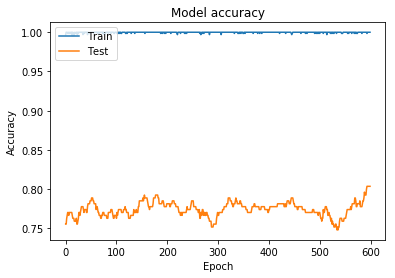

In [17]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Train and test on GT_split 3

In [18]:
Train = pickle.load(open(C.data_dir+"GT_train_3.pkl", "rb"))
Test = pickle.load(open(C.data_dir+"GT_test_3.pkl", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)

100%|██████████| 265/265 [00:00<00:00, 320.48it/s]


In [19]:
# Re-initialize weights, since training and testing data switch
DD_Net = build_DD_Net(C)

In [ ]:
import keras
lr = 1e-3
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

lr = 1e-4
DD_Net.compile(loss="categorical_crossentropy",optimizer=adam(lr),metrics=['accuracy'])
lrScheduler = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, cooldown=5, min_lr=5e-6)
history = DD_Net.fit([X_0,X_1],Y,
                    batch_size=len(Y),
                    epochs=600,
                    verbose=True,
                    shuffle=True,
                    callbacks=[lrScheduler],
                    validation_data=([X_test_0,X_test_1],Y_test)      
                    )

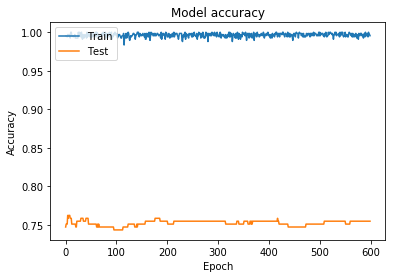

In [22]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Calculate average 

In [23]:
(0.76 + 0.80 + 0.755)/3

0.7716666666666666